In [31]:
import os
import re
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\tasnu\AppData\Roaming\Python\Python312\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [2]:
base_dirt = os.getcwd()
path = os.path.join(base_dirt, 'dataset/p3_data.csv')
data = pd.read_csv(path, encoding='ISO-8859-1')

In [3]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
corpus = data[['OriginalTweet','Sentiment']]

In [5]:
corpus.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [7]:
corpus.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [8]:
corpus['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [9]:
encoder = OrdinalEncoder(categories=[['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']])
corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])

C:\Users\tasnu\AppData\Local\Temp\ipykernel_8132\4240578442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])


In [10]:
corpus['Sentiment'].value_counts()

Sentiment
3.0    11422
1.0     9917
2.0     7713
4.0     6624
0.0     5481
Name: count, dtype: int64

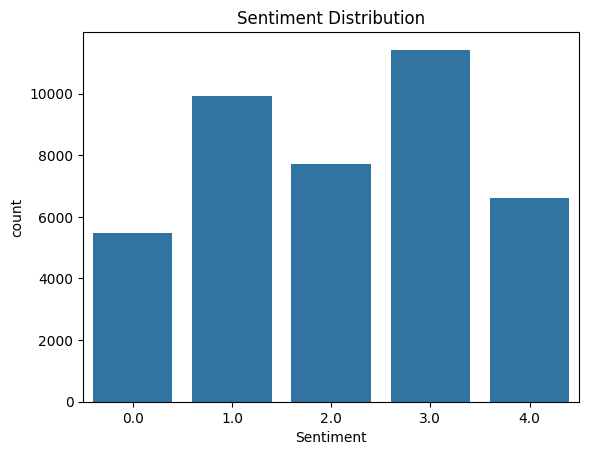

In [11]:
sns.countplot(x='Sentiment', data=corpus)
plt.title('Sentiment Distribution')
plt.show()

In [12]:
corpus['OriginalTweet'].sample(10).values

array(['Also trying to figure out how itÂ\x92s no food on the shelves at the grocery store but somehow IÂ\x92ve spent $491 on groceries this week already ? #COVID-19 #noImNotHoarding',
       'What comes to mind when the say stock up. \r\r\nBe safe out there guys. \r\r\n?????\r\r\n#solarhorss #besafe #covid_19 #lockdown #beer @ Blenco Supermarket https://t.co/IJpbeYRUIT',
       'the retail store i work at closed about a week ago in response to the COVID-19 outbreak. they promised to pay me for the hours i was already scheduled (hoping to open again april 2nd). they did this before the order for all non essential businesses to shut down for three weeks.',
       "@ymxr6 Makes my heart ache its the elderly that won't make it through the disease either and people want yo starve them too and force them out every day to expose themselves more and more because they can't bulk buy selfish b*****ds #stopthepeak #stayhome",
       'HereÂ\x92s what Galen Weston wants you to know about your loca

In [13]:
def clean_tweet(tweet):
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    return tweet

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


C:\Users\tasnu\AppData\Local\Temp\ipykernel_8132\2179563702.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


In [14]:
corpus['OriginalTweet'].sample(10).values

array(['The Lucky Charms were all gone Disappointments of a food shopper trying to stock up',
       'LAC doesn t have many instruments to respond to the st shocks oil prices There isn t much fiscal space but additional fiscal expenditure on health is unavoidable Third shock capital flight',
       'Bulletin Guidance for Business Interruption Claims Related to COVID or the March Earthquake',
       'So do grocery store employees and gas station attendants still not deserve a living wage',
       'A United States fighting a disunited battle against States bidding against each other for medical equipment Federal govt leaving states to drive up prices America no longer an example to look up to',
       'It is unwelcome when a man hits on you in the grocery store during and makes it clear that hes been watching you while you were selecting vanilla extract from the shelfand tries to get closer than feet to press forward with a conversation that was never desired',
       'This is what they 

In [15]:
corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()

C:\Users\tasnu\AppData\Local\Temp\ipykernel_8132\892715711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()


In [16]:
nltk.download('stopwords')

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    new_text = []

    for word in words:
        if word not in stop_words:
            new_text.append(word)
    
    return ' '.join(new_text)

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tasnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\tasnu\AppData\Local\Temp\ipykernel_8132\2800391941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)


In [17]:
def get_words(df, sentiment, n=10):
    sentiment_df = df[df['Sentiment'] == sentiment]

    all_words = []
    for tokens in sentiment_df['OriginalTweet']:
        for word in tokens.split():
            all_words.append(word)

    top_words = Counter(all_words).most_common(n)
    return dict(top_words)

positive_words = get_words(corpus, 3.0 , 10)
negative_words = get_words(corpus, 1.0, 10)
neutral_words = get_words(corpus, 2.0, 10)
extremely_positive_words = get_words(corpus, 4.0, 10)
extremely_negative_words = get_words(corpus, 0.0, 10)

print("Top 10 Extremely Positive Words:", extremely_positive_words)
print("Top 10 Positive Words:", positive_words)
print("Top 10 Neutral Words:", neutral_words)
print("Top 10 Negative Words:", negative_words)
print("Top 10 Extremely Negative Words:", extremely_negative_words)

Top 10 Extremely Positive Words: {'covid': 1655, 'store': 1258, 'amp': 1123, 'grocery': 1053, 'supermarket': 1032, 'help': 972, 'food': 961, 'hand': 938, 'prices': 931, 'sanitizer': 833}
Top 10 Positive Words: {'covid': 2933, 'store': 2014, 'prices': 2014, 'grocery': 1868, 'supermarket': 1814, 'food': 1718, 'people': 1429, 'amp': 1421, 'consumer': 1241, 'online': 1057}
Top 10 Neutral Words: {'covid': 1742, 'store': 1304, 'supermarket': 1241, 'prices': 1191, 'grocery': 1122, 'consumer': 904, 'shopping': 678, 'online': 666, 'food': 609, 'people': 599}
Top 10 Negative Words: {'covid': 2613, 'prices': 2350, 'food': 1941, 'supermarket': 1644, 'store': 1519, 'people': 1412, 'grocery': 1384, 'amp': 1078, 'consumer': 913, 'demand': 881}
Top 10 Extremely Negative Words: {'covid': 1539, 'food': 1531, 'prices': 1335, 'people': 1212, 'panic': 1137, 'supermarket': 902, 'crisis': 833, 'amp': 827, 'store': 662, 'buying': 646}


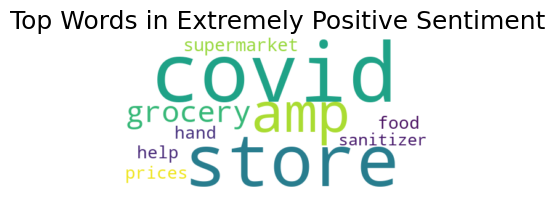

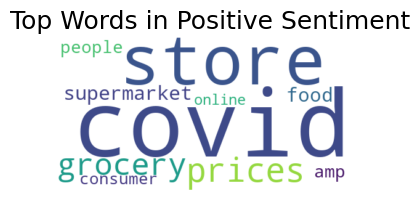

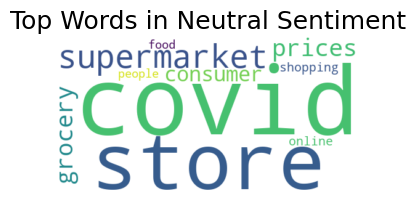

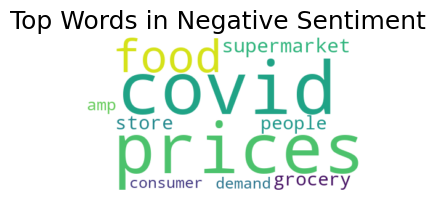

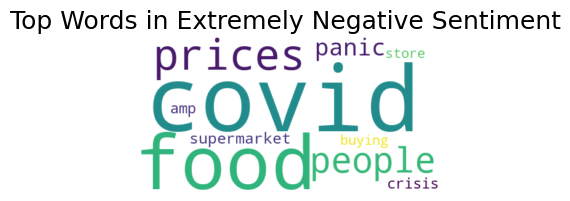

In [18]:
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=500, height=250, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(extremely_positive_words, 'Top Words in Extremely Positive Sentiment')
plot_wordcloud(positive_words, 'Top Words in Positive Sentiment')
plot_wordcloud(neutral_words, 'Top Words in Neutral Sentiment')
plot_wordcloud(negative_words, 'Top Words in Negative Sentiment')
plot_wordcloud(extremely_negative_words, 'Top Words in Extremely Negative Sentiment')

In [19]:
from nltk import ngrams

def class_ngrams(tokens, n):
    return list(ngrams(tokens, n))

def plot_ngrams(ngrams, title):
    ngram_labels = [' '.join(ngram[0]) for ngram in ngrams]
    ngram_counts = [ngram[1] for ngram in ngrams]
    
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

In [20]:
x = corpus['OriginalTweet']
y = corpus['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=50)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=50)


In [21]:
x_train

9804     great piece im son yo grocery store workers pu...
29987    treatment infection also manufactured erythrom...
14300    report manchester city manchester united donat...
7629     standard homes wont know lived without corpora...
31181    major chains beginning report first related em...
                               ...                        
21461    farmers shifting focus directtoconsumer sales ...
6055     know guy voted lowering drug prices aca denyin...
1364     sign times tissuetype paper left grocery store...
31739    exxon slashes capital spending percent oil pri...
3838     malaysia corona case gonna get lot worse blami...
Name: OriginalTweet, Length: 33336, dtype: object

In [22]:
nltk.download('punkt_tab')
x_train = x_train.apply(word_tokenize)
x_test = x_test.apply(word_tokenize)
x_cal = x_val.apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tasnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
x_train

9804     [great, piece, im, son, yo, grocery, store, wo...
29987    [treatment, infection, also, manufactured, ery...
14300    [report, manchester, city, manchester, united,...
7629     [standard, homes, wont, know, lived, without, ...
31181    [major, chains, beginning, report, first, rela...
                               ...                        
21461    [farmers, shifting, focus, directtoconsumer, s...
6055     [know, guy, voted, lowering, drug, prices, aca...
1364     [sign, times, tissuetype, paper, left, grocery...
31739    [exxon, slashes, capital, spending, percent, o...
3838     [malaysia, corona, case, gon, na, get, lot, wo...
Name: OriginalTweet, Length: 33336, dtype: object

40


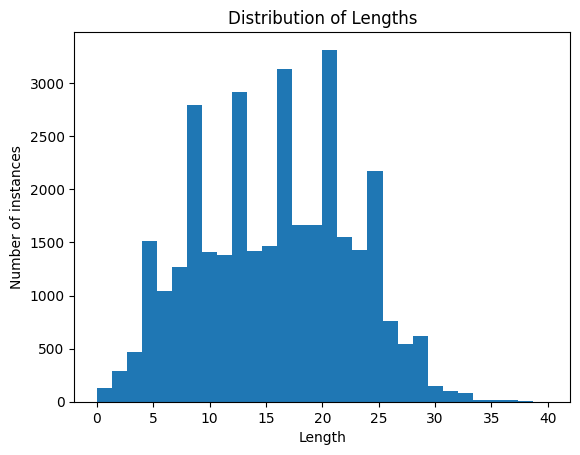

In [24]:
length = [len(token) for token in x_train]
print(max(length))

plt.hist(length, bins=30)
plt.xlabel('Length')
plt.ylabel('Number of instances')
plt.title('Distribution of Lengths')
plt.show()

In [25]:
'''
word2vec_model = Word2Vec(
    sentences= x_train,
    vector_size= 300,
    window= 10,
    min_count= 1,
    workers= 4,
    sg= 0
)

word2vec_model.build_vocab(x_train)
word2vec_model.train(x_train, total_examples=word2vec_model.corpus_count, epochs=10)

word2vec_model.save("word2vec_weights.model")
'''

'\nword2vec_model = Word2Vec(\n    sentences= x_train,\n    vector_size= 300,\n    window= 10,\n    min_count= 1,\n    workers= 4,\n    sg= 0\n)\n\nword2vec_model.build_vocab(x_train)\nword2vec_model.train(x_train, total_examples=word2vec_model.corpus_count, epochs=10)\n\nword2vec_model.save("word2vec_weights.model")\n'

In [26]:
word2vec_model = Word2Vec.load('weights/word2vec_weight.model')

In [27]:
def vector_convertor(text, model):
    vector = np.zeros(model.vector_size)
    vec_num = 0
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            vec_num += 1
            
    if vec_num != 0:
        vector = vector/vec_num
    return vector

x_train = x_train.apply(lambda token: vector_convertor(token, word2vec_model))
x_test = x_test.apply(lambda token: vector_convertor(token, word2vec_model))
x_val = x_val.apply(lambda token: vector_convertor(token, word2vec_model))

In [28]:
x_train

9804     [0.09407121805768263, 0.3801193337299322, 0.07...
29987    [-0.030605531662054684, 0.7159843343795965, -0...
14300    [0.44631877315363716, 0.05287374236754009, -0....
7629     [-0.033969457261264324, 0.2926565583329648, -0...
31181    [0.1229216070431802, 0.42909619708855945, 0.24...
                               ...                        
21461    [0.06898744627833367, -0.07944472432136536, -0...
6055     [0.05050517264236179, 0.11860723131232792, -0....
1364     [0.05674166621073433, 0.4649845576217479, 0.01...
31739    [-0.17065988971541327, 0.22107626820604007, -0...
3838     [-0.01386413446161896, 0.17622263189405202, -0...
Name: OriginalTweet, Length: 33336, dtype: object

In [29]:
vec_len = {}
for vec in x_train:
    if len(vec) not in vec_len:
        vec_len[len(vec)] = 1
    else:
        vec_len[len(vec)] += 1

print(vec_len)

{300: 33336}


In [30]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

NameError: name 'torch' is not defined

### LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out
    

In [ ]:
input_size = 300
hidden_size = 128
output_size = 5
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(y_pred, y_true):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum / y_true.shape[0]
    acc = torch.round(acc * 100)
    return acc

train_losses = []
val_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, batch_y)
    
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_outputs = model(batch_x)
            val_loss += loss_function(val_outputs.squeeze(), batch_y).item()
            val_acc += calculate_accuracy(val_outputs, batch_y)
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### GRU Model

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out


In [ ]:
input_size = 300
hidden_size = 128
output_size = 5
num_layers = 2

model = GRUModel(input_size, hidden_size, output_size, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(y_pred, y_true):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum / y_true.shape[0]
    acc = torch.round(acc * 100)
    return acc

train_losses = []
val_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, batch_y)
    
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_outputs = model(batch_x)
            val_loss += loss_function(val_outputs.squeeze(), batch_y).item()
            val_acc += calculate_accuracy(val_outputs, batch_y)
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()